# Simulation Examples
In this notebook I want to keep a log of interesting simulation examples that I find. Interesting means that they exhibit some behaviour that is e.g. not straightforward to understand. Also I would like to understand in which cases the AL approximation outperforms the UT.

## Preamble

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/python/BayesianFiltering
from codebase.utils import split_to_sigma_points
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd

Mounted at /content/drive
/content/drive/MyDrive/python/BayesianFiltering


In [1]:
g = lambda D, Pv, L, Nv, H: (2*L**2/Nv) * np.trace(Pv-D) + (1 / 4) * np.trace(np.matmul(D, H))**2

## Example 1

In this example the covariances computed by the ALA are much more accurate than the UT. The mean is comparable (probably better for the UT). 

It is an example for which the Hessian of the nonlinearity is *semi-definite*

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/python/BayesianFiltering'
/content/drive/MyDrive/python/BayesianFiltering


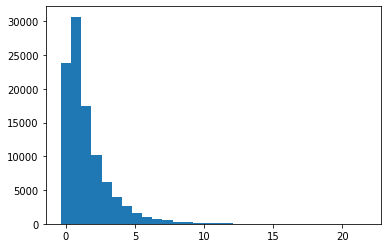

MC approx to mean of Y: 1.5029718019722504
MC approx to var of Y: 2.7692515022667217
MC approx to cov of X and Y: [-0.00599831 -0.0205239 ]


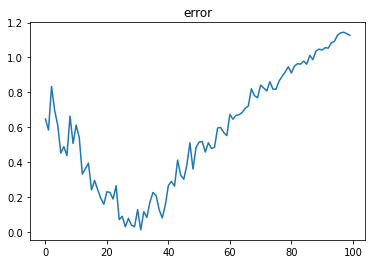

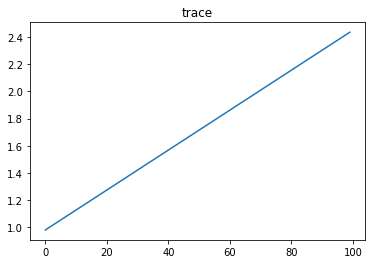

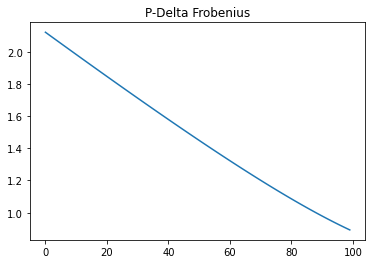

Best value: 31


,,MC,L,U,AL
0,meanY,1.502972,0.0,1.5,1.184095
1,errMean,0,1.502972,0.002972,0.318877
2,varY,2.769252,0.1,3.56875,1.83339
3,errVar,0,2.669252,0.799498,0.935861
4,covXY,"[-0.005998307501859769, -0.020523901303167325]","[0.0, 0.0]","[0.0, 0.0]","[-0.02686581720657502, 0.02074045710651142]"


In [43]:
# Preamble
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/python/BayesianFiltering
from codebase.utils import split_to_sigma_points
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd

# Simulation
dx = 2
#m = np.random.multivariate_normal(np.zeros(dx), 1*np.eye(dx)) # np.array([1]+[0]*(dx-1))
m = np.zeros(dx)
eig = np.array(range(1,dx+1))
P = np.array([[1,0.5],[0.5,2]])
Q = 0.1
dy = 1
N = 100000

# Definition of non-linearity
## 1
# p = 3
# f = lambda x: (1 + np.dot(x,x))**(p/2)
# J = lambda x : p* (1 + np.dot(x,x))**(p/2-1) * x
# H = lambda x : 2*p*(p/2-1)*(1 + np.dot(x,x))**(p/2-2)*np.outer(x,x) + np.eye(dx)*p* (1 + np.dot(x,x))**(p/2-1)

## 2
# f = lambda x: np.sin(np.dot(x,x))/np.dot(x,x)
# J = lambda x: 2 * (np.dot(x,x)*np.cos(np.dot(x,x)) - np.sin(np.dot(x,x))) / (np.dot(x,x))**2 * x
# H = lambda x: -4*(np.sin(np.dot(x,x))/np.dot(x,x) + \
#                   2*(np.cos(np.dot(x,x))*np.dot(x,x) - \
#                      np.sin(np.dot(x,x))) / np.dot(x,x)**3 ) * \
#                      np.outer(x,x) + 2 * (np.dot(x,x)*np.cos(np.dot(x,x)) - \
#                                           np.sin(np.dot(x,x))) / \
#                                           (np.dot(x,x))**2 * np.eye(dx)

## 3 Linear-Nonlinear product
# f = lambda x: x[0] * np.sin(x[1])
# J = lambda x: np.array([np.sin(x[1]), x[0]*np.cos(x[1])])
# H = lambda x: np.array([[0, np.cos(x[1])],[np.cos(x[1]), -x[0]*np.sin(x[1])]])

## 4 Linear-Nonlinear sum
# f = lambda x: x[0] + np.sin(x[1])
# J = lambda x: np.array([1, np.cos(x[1])])
# H = lambda x: np.array([[0,0],[0, -np.sin(x[1])]])

## 5 Quadratic
a = 1
b = 1
A = np.array([[a, 0 ],[0, b]])
f = lambda x: np.dot(x, np.matmul(A,x))/2
J = lambda x: np.matmul(A,x)
H = lambda x: A

# Simulation and visualization
if dx == 1:
  x = np.random.normal(m, P, size = N)
else:
  x = np.random.multivariate_normal(m, P, size = N)
y = np.array(list(map(f, x))) + np.random.normal(0, Q, N)

plt.hist(y, 30)
plt.show()


meanY_MC = np.mean(y)
varY_MC = np.var(y)
covXY_MC = np.matmul(np.transpose(x-m),y-np.mean(y))/(N-1)


print('MC approx to mean of Y:', meanY_MC)
print('MC approx to var of Y:', varY_MC)
print('MC approx to cov of X and Y:', covXY_MC)

# Linearization
meanY_L = f(m)
if dx == 1:
  varY_L = Q + J(m) * P *J(m)
  covXY_L = P * J(m)
else:
  varY_L = Q + np.dot(J(m), np.matmul(P,J(m)))
  covXY_L = np.matmul(P, J(m))

# Unscented
lam = 1
alpha = 1
beta = 1
sigma_points = split_to_sigma_points(m, P, lam)
Y_sigma_points = np.array(list(map(f, sigma_points)))

meanY_U = (lam / (dx+lam))*Y_sigma_points[0] + 1 / (2*(dx+lam)) * sum(Y_sigma_points[1:])
varY_U = Q + (lam/(dx+lam) + 1 - alpha**2 + beta) * (Y_sigma_points[0]-meanY_U)**2 + \
                           1/(2*(dx+lam)) * sum((Y_sigma_points[1:]-meanY_U)**2)

covXY_U = (lam/(dx+lam) + 1 - alpha**2 + beta)*(Y_sigma_points[0]-meanY_U)*(sigma_points[0] - m) + \
                           1/(2*(dx+lam))* np.matmul((Y_sigma_points[1:]-meanY_U), (sigma_points[1:] - m))
                        
# Augmented (search)
vals ,vecs = np.linalg.eig(H(m))
mz = np.array([0])
Nz = 1000


Nsim = 100
ev1 = 1
ev2 = 1
meanError = np.zeros(Nsim)
minEig = np.zeros(Nsim)
trace = np.zeros(Nsim)
mat_diff = np.zeros(Nsim)
for i in range(Nsim):
  ev1 = 10*0.1*0.98 
  ev2 = 0.015*i*0.98 
  Delta = np.matmul(np.matmul(vecs, np.array([[ev1, 0],[0, ev2]])),np.transpose(vecs))

  evals, evecs = np.linalg.eig(P-Delta)
  maxloc = np.argmax(evals)
  Pz = evals[maxloc]
  Gamma = evecs[maxloc]


  # MC approx of z-integral
  if Pz<0: 
    print('Error, negative variance at i=',i)
    break
  z = np.random.normal(mz, Pz, Nz)
  x_tilde = np.outer(z, Gamma) + m
  y_tilde = np.array(list(map(f, x_tilde)))
  meanY_AL = np.mean(y_tilde)
  gradients = np.array(list(map(J, x_tilde)))
  varY_AL = Q + sum((y_tilde-meanY_AL)**2)/Nz + np.trace(np.matmul(np.matmul(gradients, Delta), np.transpose(gradients)))/Nz
  covXY_AL = np.matmul(Delta, np.mean(gradients, axis =0)) + np.matmul(np.transpose(x_tilde - m), y_tilde - meanY_AL) / Nz


  meanError[i] = abs(meanY_AL - meanY_MC)
  minEig[i] = np.min(evals)
  trace[i] = np.trace(np.matmul(H(m),Delta))
  mat_diff[i] = np.sqrt(np.trace(np.matmul(P-Delta, P-Delta)))
  

plt.plot(meanError)
plt.title('error')
plt.show()
plt.plot(trace)
plt.title('trace')
plt.show()
plt.plot(mat_diff)
plt.title('P-Delta Frobenius')
plt.show()
print('Best value:', np.argmin(meanError))

# Use best value
ev1 = 10*0.1*0.98 #5
ev2 = 0.015*np.argmin(meanError)*0.98 #58
Delta = P - (np.trace(np.matmul(H(m),P)) / np.trace(np.matmul(H(m),H(m)))) * H(m)#np.matmul(np.matmul(vecs, np.array([[ev1, 0],[0, ev2]])),np.transpose(vecs))

evals, evecs = np.linalg.eig(P-Delta)
maxloc = np.argmax(evals)
Pz = evals[maxloc]
Gamma = evecs[maxloc]


# MC approx of z-integral
z = np.random.normal(mz, Pz, Nz)
x_tilde = np.outer(z, Gamma) + m
y_tilde = np.array(list(map(f, x_tilde)))
meanY_AL = np.mean(y_tilde)
gradients = np.array(list(map(J, x_tilde)))
varY_AL = Q + sum((y_tilde-meanY_AL)**2)/Nz + np.trace(np.matmul(np.matmul(gradients, Delta), np.transpose(gradients)))/Nz
covXY_AL = np.matmul(Delta, np.mean(gradients, axis =0)) + np.matmul(np.transpose(x_tilde - m), y_tilde - meanY_AL) / Nz
df = pd.DataFrame(columns = [' ','MC','L','U','AL'])
df[' '] = ['meanY', 'errMean', 'varY', 'errVar', 'covXY']
df['MC'] = [meanY_MC, 0, varY_MC, 0, covXY_MC]
df['L'] = [meanY_L, abs(meanY_L-meanY_MC), varY_L, abs(varY_L - varY_MC), covXY_L]
df['U'] = [meanY_U, abs(meanY_U-meanY_MC),varY_U, abs(varY_U - varY_MC),covXY_U]
df['AL'] = [meanY_AL, abs(meanY_AL-meanY_MC),varY_AL, abs(varY_AL - varY_MC),covXY_AL]
df

In [44]:
Delta

array([[-0.5,  0.5],
       [ 0.5,  0.5]])

### Test Gradient Descent

In [45]:
D = np.random.rand(dx,dx)
print(D)
gd_steps = 10000
eta = 0.1
L = 1
N = 1000
g = lambda D: (2*L**2/N) * np.trace(P-D) + (1/4) * np.trace(np.matmul(H(m),D))**2
for i in range(gd_steps):
  D = D + eta * (2*L**2/N) * np.eye(dx) - (eta / 2) * np.trace(np.matmul(H(m),D)) * H(m)
  print(g(D))
print(np.trace(np.matmul(H(m),D)))
D

Streaming output truncated to the last 5000 lines.
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.005996
0.00

array([[ 0.13575993,  0.93256877],
       [ 0.18964839, -0.13175993]])

In [46]:
P_perp = P - (np.trace(np.matmul(H(m),P)) / np.trace(np.matmul(H(m),H(m)))) * H(m)
P_perp

array([[-0.5,  0.5],
       [ 0.5,  0.5]])

## Experiment 1


In [18]:
# Definition of non-linearity
## 1 
p = 3
f = lambda x: (1 + np.dot(x,x))**(p/2)
J = lambda x : p * (1 + np.dot(x,x))**(p/2-1) * x
H = lambda x : 2 * p*(p/2-1)*(1 + np.dot(x,x))**(p/2-2)*np.outer(x,x) + np.eye(dx)*p* (1 + np.dot(x,x))**(p/2-1)

## 2 Sinc
# f = lambda x: np.sin(np.dot(x,x))/np.dot(x,x)
# J = lambda x: 2 * (np.dot(x,x)*np.cos(np.dot(x,x)) - np.sin(np.dot(x,x))) / (np.dot(x,x))**2 * x
# H = lambda x: -4*(np.sin(np.dot(x,x))/np.dot(x,x) + \
#                   2*(np.cos(np.dot(x,x))*np.dot(x,x) - \
#                      np.sin(np.dot(x,x))) / np.dot(x,x)**3 ) * \
#                      np.outer(x,x) + 2 * (np.dot(x,x)*np.cos(np.dot(x,x)) - \
#                                           np.sin(np.dot(x,x))) / \
#                                           (np.dot(x,x))**2 * np.eye(dx)

## 3 Linear-Nonlinear product <------------------- Hard one
# f = lambda x: x[0] * np.sin(x[1])
# J = lambda x: np.array([np.sin(x[1]), x[0]*np.cos(x[1])])
# H = lambda x: np.array([[0, np.cos(x[1])],[np.cos(x[1]), -x[0]*np.sin(x[1])]])

## 4 Linear-Nonlinear sum
# f = lambda x: x[0] + np.sin(x[1])
# J = lambda x: np.array([1, np.cos(x[1])])
# H = lambda x: np.array([[0,0],[0, -np.sin(x[1])]])

## 5 Quadratic
# a = 1
# b = 1
# A = np.array([[a, 0 ],[0, b]])
# f = lambda x: np.dot(x, np.matmul(A,x))/2
# J = lambda x: np.matmul(A, x)
# H = lambda x: A


# Fixed parameters
dx = 2
dy = 1
Q = 1 
N = 100000
Nsim = 100

# Error arrays
sqerr_mean_L = np.zeros(Nsim)
sqerr_var_L  = np.zeros(Nsim)
sqerr_mean_U = np.zeros(Nsim)
sqerr_var_U  = np.zeros(Nsim)
sqerr_mean_AL1 = np.zeros(Nsim)
sqerr_var_AL1  = np.zeros(Nsim)
sqerr_mean_AL2 = np.zeros(Nsim)
sqerr_var_AL2  = np.zeros(Nsim)
sqerr_mean_MC100 = np.zeros(Nsim)
sqerr_var_MC100  = np.zeros(Nsim)

est_mean_MC = np.zeros(Nsim)
est_var_MC  = np.zeros(Nsim)
est_mean_L = np.zeros(Nsim)
est_var_L  = np.zeros(Nsim)
est_mean_U = np.zeros(Nsim)
est_var_U  = np.zeros(Nsim)
est_mean_AL1 = np.zeros(Nsim)
est_var_AL1  = np.zeros(Nsim)
est_mean_AL2 = np.zeros(Nsim)
est_var_AL2  = np.zeros(Nsim)

# ## Choice of m and P
# m = np.random.multivariate_normal(np.zeros(dx), 100*np.eye(dx)) 
# A = 10*np.random.rand(dx, dx)
# P = np.dot(A, A.transpose())


for i in range(Nsim):

  ## Simulation  ###############################################################
  if dx == 1:
    x = np.random.normal(m, P, size = N)
  else:
    x = np.random.multivariate_normal(m, P, size = N)
  y = np.array(list(map(f, x))) + np.random.normal(0, Q, N)

  meanY_MC = np.mean(y)
  varY_MC = np.var(y)
  covXY_MC = np.matmul(np.transpose(x-m),y-np.mean(y))/(N-1)

  ## MC 100
  if dx == 1:
    x = np.random.normal(m, P, size = 100)
  else:
    x = np.random.multivariate_normal(m, P, size = 100)
  y = np.array(list(map(f, x)))
  meanY_MC100 = np.mean(y)
  varY_MC100 = np.var(y)
  covXY_MC100 = np.matmul(np.transpose(x-m), y-np.mean(y))/(100-1)

  ## Taylor ####################################################################
  meanY_L = f(m) + (1/2) * np.trace(np.matmul(H(m), P))
  if dx == 1:
    varY_L = Q + J(m) * P *J(m) 
    covXY_L = P * J(m)
  else:
    varY_L = Q + np.dot(J(m), np.matmul(P,J(m))) + (1/2) * np.trace(np.matmul(np.matmul(H(m), P), np.matmul(H(m), P)))
    covXY_L = np.matmul(P, J(m))

  ## Unscented #################################################################
  alpha = 1e-3
  beta = 2
  lam = (alpha**2-1)*dx
  sigma_points = split_to_sigma_points(m, P, lam)
  Y_sigma_points = np.array(list(map(f, sigma_points)))

  meanY_U = (lam / (dx+lam)) * Y_sigma_points[0] + 1 / (2*(dx+lam)) * sum(Y_sigma_points[1:])
  varY_U = Q + (lam/(dx+lam) + 1 - alpha**2 + beta) * (Y_sigma_points[0]-meanY_U)**2 + \
                            1/(2*(dx+lam)) * sum((Y_sigma_points[1:]-meanY_U)**2)

  covXY_U = (lam/(dx+lam) + 1 - alpha**2 + beta) * (Y_sigma_points[0]-meanY_U) * (sigma_points[0] - m) + \
                            1/(2*(dx+lam))* np.matmul((Y_sigma_points[1:]-meanY_U), (sigma_points[1:] - m))
                        
  ## Augmented #################################################################
  Nz = 1000
  # m=1 ###############
  mz = np.array([0])

  # Projection
  if abs(np.trace(H(m))) > 0.01:
    Delta = P - (np.trace(np.matmul(H(m),P)) / np.trace(np.matmul(H(m),H(m)))) * H(m)
  else:
    Delta = P

  evals, evecs = np.linalg.eig(P-Delta)
  maxloc = np.argmax(evals)
  Pz = evals[maxloc]
  Gamma = evecs[maxloc]

  # MC approx of z-integral
  if Pz<0: 
    print('Error, negative variance at i=',i)
  else:
    z = np.random.normal(mz, Pz, Nz)
    x_tilde = np.outer(z, Gamma) + m
    y_tilde = np.array(list(map(f, x_tilde)))
    meanY_AL1 = np.mean(y_tilde)
    gradients = np.array(list(map(J, x_tilde)))
    varY_AL1 = Q + sum((y_tilde-meanY_AL1)**2)/Nz + np.trace(np.matmul(np.matmul(gradients, Delta), np.transpose(gradients)))/Nz
    covXY_AL1 = np.matmul(Delta, np.mean(gradients, axis =0)) + np.matmul(np.transpose(x_tilde - m), y_tilde - meanY_AL1) / Nz

  # m=2 ###############

  # Projection 
  if abs(np.trace(H(m))) > 0.01:
    Pi = np.linalg.cholesky(P)
    S = np.linalg.cholesky(H(m))
    Lambda = Pi - (np.trace(np.matmul(np.transpose(S),Pi)) / np.trace(np.matmul(np.transpose(S),S))) * S
    Delta = 0.1*np.matmul(np.transpose(Lambda), Lambda)
    #Delta = P - (np.trace(np.matmul(H(m),P)) / np.trace(np.matmul(H(m),H(m)))) * H(m)
  else:
    Delta = P

  mz = m
  Pz = P-Delta

  # # MC approx of z-integral
  z = np.random.multivariate_normal(mz, Pz, Nz)
  x_tilde = z
  y_tilde = np.array(list(map(f, x_tilde)))
  meanY_AL2 = np.mean(y_tilde)
  gradients = np.array(list(map(J, x_tilde)))
  varY_AL2 = Q + sum((y_tilde-meanY_AL2)**2)/Nz + np.trace(np.matmul(np.matmul(gradients, Delta), np.transpose(gradients)))/Nz
  covXY_AL2 = np.matmul(Delta, np.mean(gradients, axis =0)) + np.matmul(np.transpose(x_tilde - m), y_tilde - meanY_AL2) / Nz

  ############## Computation of errors #######################



  sqerr_mean_L[i] = (meanY_L-meanY_MC)**2 
  sqerr_var_L[i]  = (varY_L - varY_MC)**2
  sqerr_mean_U[i] = (meanY_U-meanY_MC)**2 
  sqerr_var_U[i]  = (varY_U - varY_MC)**2
  sqerr_mean_AL1[i] = (meanY_AL1-meanY_MC)**2 
  sqerr_var_AL1[i]  = (varY_AL1 - varY_MC)**2
  sqerr_mean_AL2[i] = (meanY_AL2 - meanY_MC)**2 
  sqerr_var_AL2[i]  = (varY_AL2 - varY_MC)**2
  sqerr_mean_MC100[i] = (meanY_MC100 - meanY_MC)**2 
  sqerr_var_MC100[i]  = (varY_MC100 - varY_MC)**2

  est_mean_MC[i] = meanY_MC
  est_var_MC[i] = varY_MC
  est_mean_L[i] = meanY_L
  est_var_L[i]  = varY_L
  est_mean_U[i] = meanY_U
  est_var_U[i]  = varY_U
  est_mean_AL1[i] = meanY_AL1
  est_var_AL1[i]  = varY_AL1
  est_mean_AL2[i] = meanY_AL2
  est_var_AL2[i]  = varY_AL2

print('Taylor mean MSE', np.mean(sqerr_mean_L))
print('Taylor var MSE', np.mean(sqerr_var_L))
print('Unscented mean MSE', np.mean(sqerr_mean_U))
print('Unscented var MSE', np.mean(sqerr_var_U))
print('AL1 mean MSE', np.mean(sqerr_mean_AL1))
print('AL1 var MSE', np.mean(sqerr_var_AL1))
print('AL2 mean MSE', np.mean(sqerr_mean_AL2))
print('AL2 var MSE', np.mean(sqerr_var_AL2))

Taylor mean MSE 13742.17775711231
Taylor var MSE 947587388422.721
Unscented mean MSE 13742.170654367654
Unscented var MSE 817382891476.5596
AL1 mean MSE 411080346.73452115
AL1 var MSE 4.765210701326823e+18
AL2 mean MSE 1754.9192439989906
AL2 var MSE 60609966973.02247


In [19]:
df = pd.DataFrame(columns = [' ','MC100','Taylor','Unscented','AL1','AL2'])
df[' '] = ['mean MSE', 'var MSE']
df['MC100'] = [np.mean(sqerr_mean_MC100), np.mean(sqerr_var_MC100)]
df['Taylor'] = [np.mean(sqerr_mean_L),np.mean(sqerr_var_L)]
df['Unscented'] = [np.mean(sqerr_mean_U), np.mean(sqerr_var_U)]
df['AL1'] = [np.mean(sqerr_mean_AL1), np.mean(sqerr_var_AL1)]
df['AL2'] = [np.mean(sqerr_mean_AL2), np.mean(sqerr_var_AL2)]
#print(df.to_latex(index=False))  
df

,,MC100,Taylor,Unscented,AL1,AL2
0,mean MSE,1.372467e+04,1.374218e+04,1.374217e+04,4.110803e+08,1.754919e+03
1,var MSE,4.742521e+11,9.475874e+11,8.173829e+11,4.765211e+18,6.060997e+10


In [21]:
Pi = np.linalg.cholesky(P)
S = np.linalg.cholesky(H(m))
Lambda = Pi - (np.trace(np.matmul(np.transpose(S),Pi)) / np.trace(np.matmul(np.transpose(S),S))) * S
D = np.matmul(np.transpose(Lambda), Lambda)
print(D)
print(np.linalg.eig(P-0.1*Delta))
g(0.1*Delta, P, 1, Nz, H(m))

[[10.17121112  6.49390872]
 [ 6.49390872  4.90857526]]
(array([ 3.71300628, 34.96236236]), array([[-0.99312508, -0.11705798],
       [ 0.11705798, -0.99312508]]))


1.7071766387947356

In [20]:
df_est = pd.DataFrame(columns = ['mean MC', 'var MC', 'mean Taylor', 'var Taylor',
                                 'mean Unscented', 'var Unscented', 'mean AL1', 
                                 'var AL1', 'mean AL2', 'var AL2'])
df_est['mean MC'] =  est_mean_MC
df_est['var MC']  = est_var_MC
df_est['mean Taylor'] = est_mean_L 
df_est['var Taylor'] = est_var_L
df_est['mean Unscented'] = est_mean_U
df_est['var Unscented'] = est_var_U
df_est['mean AL1'] = est_mean_AL1
df_est['var AL1']= est_var_AL1
df_est['mean AL2'] = est_mean_AL2
df_est['var AL2']= est_var_AL2
df_est

,mean MC,var MC,mean Taylor,var Taylor,mean Unscented,var Unscented,mean AL1,var AL1,mean AL2,var AL2
0,746.203146,1.524858e+06,627.386425,512788.161929,627.386455,582168.059784,21791.987585,2.154324e+09,742.314238,1.411779e+06
1,742.546990,1.462059e+06,627.386425,512788.161929,627.386455,582168.059784,19687.654087,1.513519e+09,745.876968,1.489314e+06
2,745.085648,1.474964e+06,627.386425,512788.161929,627.386455,582168.059784,23284.460694,3.174652e+09,724.323111,1.635462e+06
3,743.985520,1.475330e+06,627.386425,512788.161929,627.386455,582168.059784,21060.024158,1.962049e+09,690.037682,1.182520e+06
4,750.399892,1.494812e+06,627.386425,512788.161929,627.386455,582168.059784,21573.735226,1.844879e+09,666.344422,1.600686e+06
...,...,...,...,...,...,...,...,...,...,...
95,748.660720,1.550289e+06,627.386425,512788.161929,627.386455,582168.059784,23239.240464,2.302967e+09,780.457784,1.834811e+06
96,736.933256,1.455500e+06,627.386425,512788.161929,627.386455,582168.059784,20096.777111,2.016204e+09,669.309171,9.911385e+05
97,744.278444,1.494574e+06,627.386425,512788.161929,627.386455,582168.059784,17200.267488,1.195032e+09,743.098992,1.436143e+06
98,744.187123,1.489884e+06,627.386425,512788.161929,627.386455,582168.059784,18663.473906,1.544937e+09,691.095857,1.304048e+06
